![Titanic](images/Titanic-Sinking.jpg)
<center>Kapal Titanic yang tenggelam</center>

Studi kasus kali ini anda akan 
1. membangun model prediksi apakah penumpang kapal Titanic akan selamat atau tidak.    
Adapun, dua model prediksi yang akan dibuat adalah **Logistic Regression** dan **Random Forest**.
2. Setelah dua model tersebut dilatih dan digunakan untuk memprediksi pada _test set_, anda akan memplot beberapa grafik.
   
      
      
Grafik-grafik yang akan diplot adalah
- plot _threshold_ sebagai sumbu $x$ terhadap recall dan precision sebagai sumbu $y$.
- plot _recall_ sebagai sumbu $x$ terhadap _precision_ sebagai sumbu $y$. 
- plot kurva ROC (**Receiver Operating Characteristic**)


# Part I: Model Prediksi

We import all the needed libraries.

In [5]:
%matplotlib inline

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np

In [7]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Kita siapkan method untuk menyimpan gambar, `save_fig`.

In [8]:
from pathlib import Path

IMAGES_PATH = Path() / "images"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Help Titanic Passengers!

Kita siapkan _path_ untuk dataset.

In [9]:
data_path = Path("Titanic/")

Kita baca file training, `train.csv`.

In [10]:
data_titanic = pd.read_csv(data_path / "train.csv")

Kita lihat 5 baris pertama dari `data_titanic`.

In [11]:
data_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Kita lihat statistika dari dataset.

In [12]:
data_titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Dari statistika dataset untuk kolom-kolom yang berupa angka, kita melihat bahwa terdapat $7$ attributes angka atau numerik sbb:     
1. `PassengerId` $\Rightarrow$ nomor identitas penumpang
2. `Survived` $\Rightarrow$ selamat (`1`) atau tidak selamat (`0`)
3. `Pclass`  $\Rightarrow$ kelas penumpang
4. `Age` $\Rightarrow$ umur penumpang
5. `SibSp`$\Rightarrow$ Jumlah saudara & saudari dan pasangan dalam kapal Titanic
6. `Parch` $\Rightarrow$ Jumlah parent & anak yang ikut dalam kapal Titanic
7. `Fare` $\Rightarrow$ Ongkos naik kapal Titanic.


Kita lihat jumlah baris dan kolom dari dataset sbb:

In [13]:
data_titanic.shape

(891, 12)

Mari kita tampilkan jumlah baris yang kosong atau `null`.

In [14]:
data_titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

Kita buang empat kolom atau `attributes`, yaitu:
1. `PassengerId`
2. `Name`
3. `Ticket`
4. `Cabin`

In [15]:
data_titanic.drop('PassengerId',axis=1, inplace=True) 
data_titanic.drop('Name',axis=1, inplace=True) 
data_titanic.drop('Ticket',axis=1, inplace=True) 
data_titanic.drop('Cabin',axis=1, inplace=True) 

Terlihat sekarang bahwa jumlah kolom sekarang adalah `8`.

In [16]:
data_titanic.shape

(891, 8)

Mari kita tampilkan lima baris pertama dari dataset.

In [17]:
data_titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [18]:
data_titanic.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      0
dtype: int64

Terlihat bahwa masih terdapat `177` baris yang `null` atau kosong.    
Oleh karena itu, kita akan mengisi nilai `null` atau kosong ini dengan rata-rata `Age`.

In [19]:
a_mean = data_titanic['Age'].mean()
data_titanic['Age'].fillna(a_mean, inplace=True)

In [20]:
data_titanic.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

Sekarang semua baris sudah memiliki nilai `Age`.

In [21]:
data_titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Selanjutnya, kita akan mengubah `Sex` menjadi `0` (_female_) dan `1` (_male_).

In [22]:
ordinal_encoder = OrdinalEncoder()
sex_cat = data_titanic['Sex'].to_numpy()
sex_cat = sex_cat.reshape((sex_cat.shape[0], 1))

data_titanic['Sex'] = ordinal_encoder.fit_transform(sex_cat)

In [23]:
data_titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1.0,22.0,1,0,7.2500,S
1,1,1,0.0,38.0,1,0,71.2833,C
2,1,3,0.0,26.0,0,0,7.9250,S
3,1,1,0.0,35.0,1,0,53.1000,S
4,0,3,1.0,35.0,0,0,8.0500,S


Kolom `Embarked` menunjukkan pelabuhan tempat penumpang naik kapal Titanic. Terdapat tiga pelabuhan yang mungkin, yaitu: Southampton (`S`), Cherbourg (`C`), dan Queenstown `Q`.     
Kemudian kita akan mengubah kolom `Embarked` menjadi _one-hot encoding_.

In [24]:
data_titanic = pd.get_dummies(data_titanic)

In [25]:
data_titanic.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,29.699118,0.523008,0.381594,32.204208,0.188552,0.086420,0.725028
std,0.486592,0.836071,0.477990,13.002015,1.102743,0.806057,49.693429,0.391372,0.281141,0.446751
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000
50%,0.000000,3.000000,1.000000,29.699118,0.000000,0.000000,14.454200,0.000000,0.000000,1.000000
75%,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,0.000000,0.000000,1.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000


Mari kita tampilkan $5$ baris teratas dari dataset sekarang.

In [26]:
data_titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,0,3,1.0,22.0,1,0,7.2500,0,0,1
1,1,1,0.0,38.0,1,0,71.2833,1,0,0
2,1,3,0.0,26.0,0,0,7.9250,0,0,1
3,1,1,0.0,35.0,1,0,53.1000,0,0,1
4,0,3,1.0,35.0,0,0,8.0500,0,0,1


### Preprocessing the Train Set

Kita bagi dataset menjadi _train_ dan _test set_.

In [27]:
train_set, test_set = train_test_split(data_titanic, test_size=0.2, random_state=42)

Kita akan melakukan normalisasi kolom-kolom numerik, yaitu `Pclass`, `Age`, `SibSp`, `Parch`, `Fare`.    
Normalisasi yang digunakan adalah mengubah nilai kolom menjadi [`standard score`](https://en.wikipedia.org/wiki/Standard_score).

In [28]:
train_set_num = train_set[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']]

In [29]:
train_set_num.head()

,Pclass,Age,SibSp,Parch,Fare
331,1,45.5,0,0,28.5000
733,2,23.0,0,0,13.0000
382,3,32.0,0,0,7.9250
704,3,26.0,1,0,7.8542
813,3,6.0,4,2,31.2750


In [30]:
scaler = StandardScaler()
train_set_num = scaler.fit_transform(train_set_num)

In [31]:
train_set_part_1 = train_set.drop(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], axis=1)

In [32]:
train_set_part_1 = train_set_part_1.to_numpy()

In [33]:
train_set_prepared = np.concatenate((train_set_part_1, train_set_num), axis=1  )

In [34]:
train_set_prepared[:5,:]

array([[ 0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
        -1.61413602,  1.22920747, -0.47072241, -0.47934164, -0.07868358],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
        -0.40055118, -0.50350514, -0.47072241, -0.47934164, -0.37714494],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
         0.81303367,  0.18957991, -0.47072241, -0.47934164, -0.47486697],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
         0.81303367, -0.27247679,  0.37992316, -0.47934164, -0.47623026],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.81303367, -1.81266577,  2.93185988,  2.04874166, -0.02524937]])

### Preprocessing the Test Set

Hal yang sama juga dilakukan pada **test set**.

In [35]:
test_set_num = test_set[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']]

In [36]:
test_set_num.head()

,Pclass,Age,SibSp,Parch,Fare
709,3,29.699118,1,1,15.2458
439,2,31.000000,0,0,10.5000
840,3,20.000000,0,0,7.9250
720,2,6.000000,0,1,33.0000
39,3,14.000000,1,0,11.2417


**Hati-Hati**: please use the _mean_ and _std_ from the train set.  

In [37]:
test_set_num = scaler.transform(test_set_num)

In [38]:
test_set_part_1 = test_set.drop(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], axis=1)

In [39]:
test_set_part_1 = test_set_part_1.to_numpy()

In [40]:
test_set_prepared = np.concatenate((test_set_part_1, test_set_num), axis=1  )

In [41]:
X_train = train_set_prepared[:,1:]
y_train = train_set_prepared[:,0]
y_train = y_train.reshape((y_train.shape[0] ,1))
y_train = y_train.ravel()

X_test = test_set_prepared[:,1:]
y_test = test_set_prepared[:,0]
y_test = y_test.reshape((y_test.shape[0] ,1))
y_test = y_test.ravel()

Sekarang kita mempunyai dataset yang sudah terbagi menjadi 
- `X_train`,
- `y_train`,
- `X_test`, dan
- `y_test`.

### Melatih Model _Logistic Regression_

Kita akan membuat `log_reg` yang merupakan _instance_ dari kelas `LogisticRegression`. 

In [42]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()

Selanjutnya, kita melatih `log_reg` dengan menggunakan `X_train` dan `y_train`.

In [43]:
log_reg.fit(X_train,y_train)

LogisticRegression()

Gunakan model _logistic regression_ `log_reg` untuk memprediksi `X_test`.

In [44]:
y_pred = log_reg.predict(X_test)


Buatlah _confusion matrix_ dari hasil prediksi (`y_pred`) dan _true values_ (`y_test`).     
Tampilkan _confusion matrix_ tersebut.

In [48]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_pred, y_test)
cm

array([[90, 19],
       [15, 55]], dtype=int64)

Hitunglah _accuracy_ dari model `log_reg`.    
**Hint**: anda dapat menggunakan `accuracy_score`.

In [57]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)


0.8100558659217877

Hitunglah _precision_ dari model `log_reg`.    
**Hint**: anda dapat menggunakan `precision_score`.

In [58]:
from sklearn.metrics import precision_score
precision_score(y_test, y_pred)

0.7857142857142857

Hitunglah _recall_ dari model `log_reg`.    
**Hint**: anda dapat menggunakan `recall_score`.

In [59]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred)

0.7432432432432432

Hitunglah $F_1$ _score_ dari model `log_reg`.    
**Hint**: anda dapat menggunakan `f1_score`.

In [60]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

0.7638888888888888

### Melatih Model _Random Forest_

Buatlah instance dari model `RandomForestClassifier` yang bernama `forest_clf` dengan `random_state` yang bernilai `42`.

In [61]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)


Latihlah model `forest_clf` pada `X_train` dan `y_train`.

In [62]:
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Gunakan `forest_clf` untuk memprediksi pada `X_test`.

In [64]:
y_predRFC = forest_clf.predict(X_test)

Selanjutnya, hitunglah _accuracy_ dari model `forest_clf`.    

In [65]:
forest_scores = accuracy_score(y_test, y_pred)
forest_scores

0.8156424581005587

Selanjutnya, hitunglah _precision_ dari model `forest_clf`.    

In [66]:
precision_score(y_test, y_pred)


0.8059701492537313

Selanjutnya, hitunglah _recall_ dari model `forest_clf`.    

In [67]:
recall_score(y_test, y_pred)


0.7297297297297297

Selanjutnya, hitunglah $F_1$ _score_ dari model `forest_clf`.    

In [68]:
f1_score(y_test, y_pred)


0.7659574468085106

# Part II: Plotting Kurva-Kurva

Part II membahas tentang menggambar kurva-kurva, yaitu:
- kurva _precision_ & _recall_ vs. _threshold_.
- kurva _precision_ vs. _recall_.
- kurva ROC.

Hitunglah _scores_ dari model `log_reg` dengan menggunakan `decision_function`

In [79]:
from sklearn.model_selection import cross_val_predict
y_scores = cross_val_predict(log_reg, X_train, y_train, cv=3,
                             method="decision_function")

Gunakan `precision_recall_curve` dengan menggunakan `y_train` dan `y_scores` untuk menghasilkan `precisions`, `recalls`, dan `thresholds`.

In [80]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)


Buatlah variabel yang bernama `threshold` dan beri nilai `threshold` adalah `0`.

In [83]:
threshold = 0


Buatlah kurva _precision_ & _recall_ vs. _threshold_ dengan sumbu $x$ dari $-5$ s.d. $4$.   
**Hint**: Baca kode program (Geron, 2023) di Figure 3-5 hlm. 113.

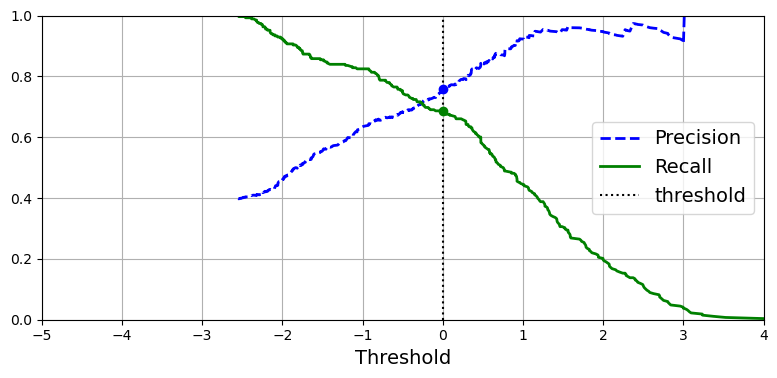

In [84]:
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-5, 4, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
save_fig("precision_recall_vs_threshold_plot")

plt.show()

Buatlah kurva Precision-Recall dari model `log_reg`.    
**Hint**: Baca kode program (Geron, 2023) di Figure 3-6 hlm. 114.

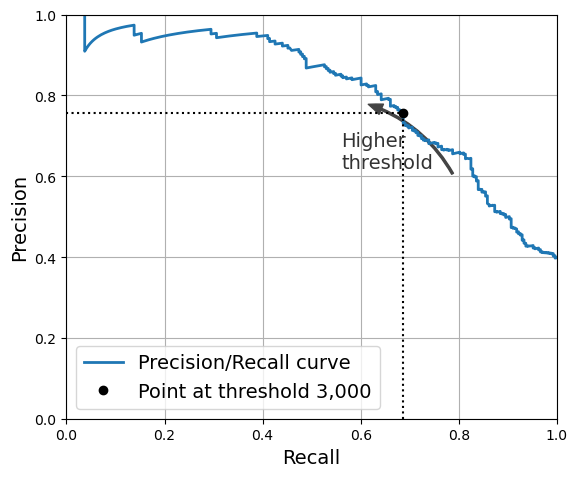

In [85]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("precision_vs_recall_plot")

plt.show()

Selanjutnya, kita akan membuat kurva ROC seperti pada hlm. 115 (Geron, 2023).     
Gunakan method `roc_curve` dengan untuk menghasilkan _False Positive Rate_, _True Positive Rate_, dan _Thresholds_.

In [86]:
from sklearn.metrics import roc_curve


fpr, tpr, thresholds = roc_curve(y_train, y_scores)


Buatlah threshold untuk 81% precision dengan nama variabel `threshold_for_81_precision`.

In [110]:
threshold_for_81_precision = 0.81

Hitunglah nilai `y_scores` $\geq$ `threshold_for_81_precision` dan hasilnya disimpan di `y_train_pred_81`.

In [111]:
y_train_pred_81 = (y_scores >= threshold_for_81_precision)

Hitunglah **precision** dengan menggunakan `precision_score` dengan parameter: `y_train` dan `y_train_pred_81`. 

In [112]:
precision_score(y_train, y_train_pred_81)

0.8904109589041096

Hitunglah **recall** dengan menggunakan `recall_score` dengan parameter: `y_train` dan `y_train_pred_81` dan simpan hasil recall di variabel `recall_at_81_precision`.

In [114]:
recall_at_81_precision = recall_score(y_train, y_train_pred_81)
recall_at_81_precision

0.48507462686567165

Buatlah kurva ROC dari model `log_reg`.    
**Hint**: Baca kode program (Geron, 2023) di Figure 3-7 hlm. 116.

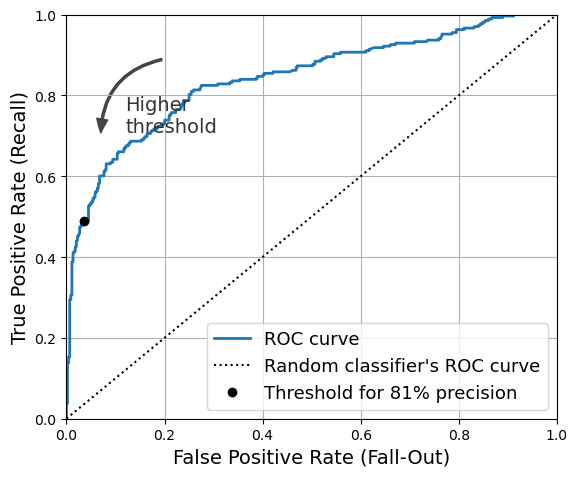

In [118]:
idx_for_threshold_at_81 = (thresholds <= threshold_for_81_precision).argmax()
tpr_81, fpr_81 = tpr[idx_for_threshold_at_81], fpr[idx_for_threshold_at_81]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 81% precision")

# extra code – just beautifies and saves Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
save_fig("roc_curve_plot")

plt.show()

<center><h1>The End</h1></center>